In [117]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import lit
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import seaborn as sns
import random
from pprint import pprint
from pyspark.sql import functions as func
from pyspark.sql.functions import monotonically_increasing_id
%matplotlib inline
sns.set_style("darkgrid")
from pyspark.sql.functions import round
from pyspark.sql.types import *
from pandas.plotting import scatter_matrix
import ast
from pyspark.sql.functions import udf, array
from pyspark.sql.types import StringType,DoubleType
from pyspark.sql.functions import col
import missingno as msno
from sklearn.model_selection import train_test_split, GridSearchCV
from pyspark.sql import SparkSession
#Create PySpark SparkSession


In [118]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [119]:
spark = SparkSession.builder.master("local[*]").appName("Do An Big Data").getOrCreate()

## Đọc File dataset

In [120]:
df = pd.read_csv('hotel_bookings.csv')
df = df.sample(10000)
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
69704,City Hotel,1,173,2017,June,23,4,2,2,2,...,Non Refund,37.0,NaN,0,Transient,120.00,0,0,Canceled,2016-12-13
97516,City Hotel,0,17,2016,September,38,16,0,1,2,...,No Deposit,9.0,NaN,0,Transient,183.00,0,1,Check-Out,2016-09-17
34791,Resort Hotel,0,89,2017,April,14,3,1,1,2,...,No Deposit,240.0,NaN,0,Transient,194.00,0,0,Check-Out,2017-04-05
48915,City Hotel,1,79,2016,April,14,2,1,1,2,...,No Deposit,9.0,NaN,0,Transient,76.50,0,0,Canceled,2016-01-14
34836,Resort Hotel,0,10,2017,April,15,10,1,3,2,...,No Deposit,146.0,NaN,0,Group,61.00,0,1,Check-Out,2017-04-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46752,City Hotel,0,151,2016,January,4,19,0,2,1,...,No Deposit,19.0,NaN,63,Transient-Party,71.00,0,0,Check-Out,2016-01-21
62351,City Hotel,1,3,2017,January,2,10,0,4,2,...,No Deposit,9.0,NaN,0,Transient,83.09,0,1,No-Show,2017-01-10
3674,Resort Hotel,0,165,2015,December,53,30,0,4,1,...,No Deposit,308.0,NaN,122,Transient-Party,84.50,0,0,Check-Out,2016-01-03
76150,City Hotel,1,273,2015,July,29,17,0,2,2,...,No Deposit,6.0,NaN,0,Transient-Party,101.50,0,0,Canceled,2015-07-06


## Xem thông tin data và tiến hành tiền xử lí dữ liệu:

In [121]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,8639.000000,589.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.368400,103.602400,2016.155000,27.071400,15.841100,0.90640,2.508400,1.856500,0.103900,0.009800,0.032500,0.084400,0.153300,0.231200,85.016553,185.288625,2.208300,101.506341,0.059400,0.580000
std,0.482395,107.272943,0.709807,13.699718,8.711753,0.97218,1.817872,0.518203,0.395627,0.138224,0.177333,0.806686,1.704432,0.701424,109.912462,133.936304,16.902866,48.401405,0.237228,0.786551
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,9.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.00000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,47.000000,0.000000,69.000000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.00000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,174.000000,0.000000,94.500000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.00000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,208.000000,274.000000,0.000000,125.100000,0.000000,1.000000
max,1.000000,629.000000,2017.000000,53.000000,31.000000,10.00000,21.000000,20.000000,3.000000,10.000000,1.000000,24.000000,63.000000,14.000000,535.000000,531.000000,391.000000,426.250000,2.000000,5.000000


In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 69704 to 55131
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           10000 non-null  object 
 1   is_canceled                     10000 non-null  int64  
 2   lead_time                       10000 non-null  int64  
 3   arrival_date_year               10000 non-null  int64  
 4   arrival_date_month              10000 non-null  object 
 5   arrival_date_week_number        10000 non-null  int64  
 6   arrival_date_day_of_month       10000 non-null  int64  
 7   stays_in_weekend_nights         10000 non-null  int64  
 8   stays_in_week_nights            10000 non-null  int64  
 9   adults                          10000 non-null  int64  
 10  children                        10000 non-null  float64
 11  babies                          10000 non-null  int64  
 12  meal                        

kiểm tra các giá trị null trong dữ liệu:


In [123]:
null = pd.DataFrame({'Null Values' : df.isna().sum(), 'Percentage Null Values' : (df.isna().sum()) / (df.shape[0]) * (100)})
null

,Null Values,Percentage Null Values
hotel,0,0.00
is_canceled,0,0.00
lead_time,0,0.00
arrival_date_year,0,0.00
arrival_date_month,0,0.00
arrival_date_week_number,0,0.00
arrival_date_day_of_month,0,0.00
stays_in_weekend_nights,0,0.00
stays_in_week_nights,0,0.00
adults,0,0.00


### Sau khi liệt kê các giá trị null trong data ta tiến hành điền các giá trị rỗng = 0.

<AxesSubplot:>

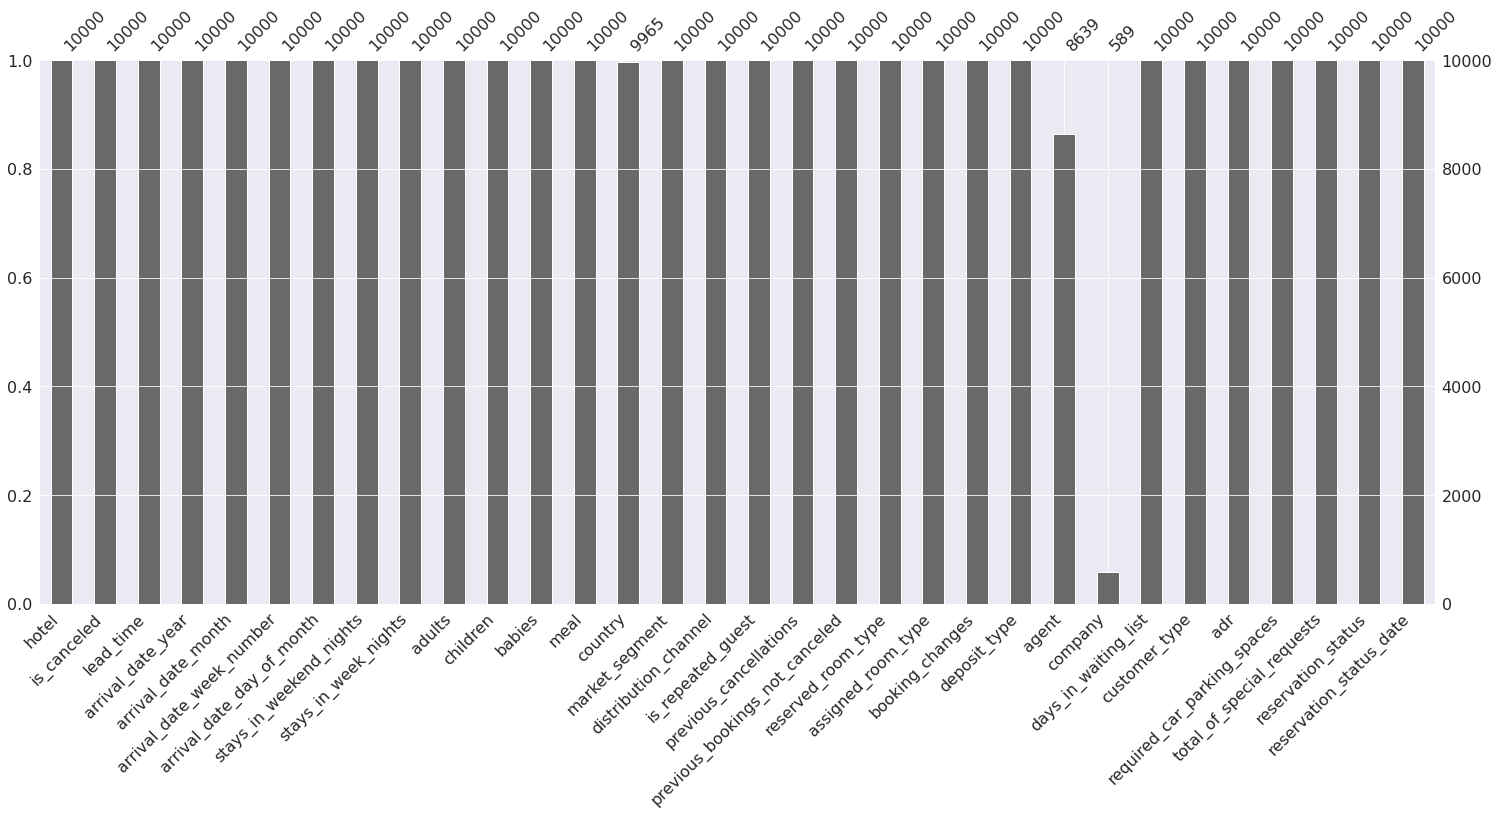

In [124]:
msno.bar(df)


In [125]:
df.fillna(0, inplace = True)

<AxesSubplot:>

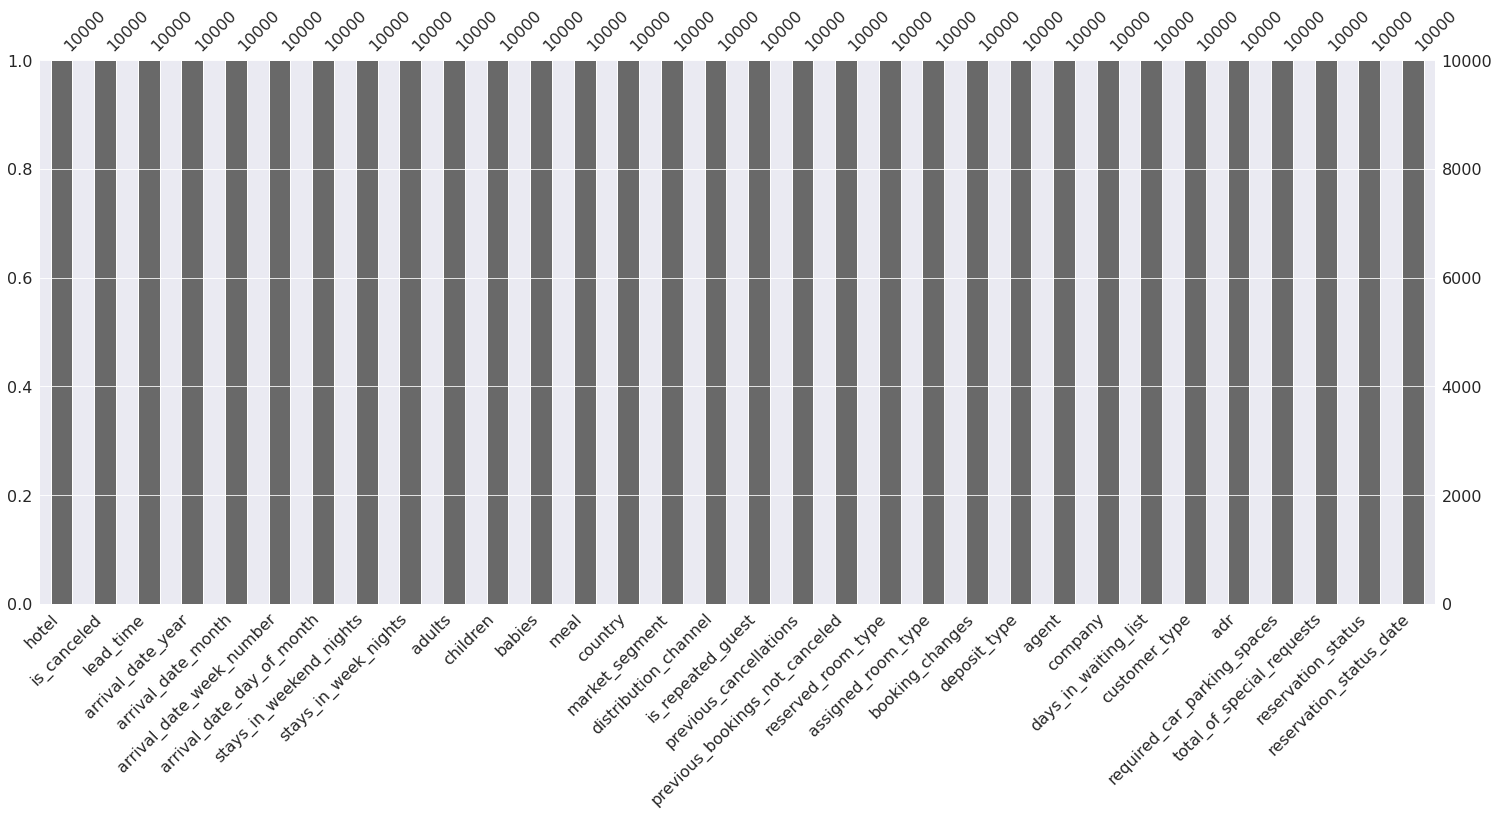

In [126]:
msno.bar(df)

hiển thị ra các giá trị null

Ta thấy trong dữ liệu có cột dữ liệu người lớn(adults) và cột dữ liệu trẻ em(children)
và 2 cột này không thể đồng thời bằng 0 nên ta loại đi những dòng dữ liệu có cả 2 giá trị này đều bằng 0. 






In [127]:
#liệt kê ra 
filter = (df.children == 0) & (df.adults == 0) & (df.babies == 0)
df[filter]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
107027,City Hotel,0,2,2017,March,10,6,0,0,0,...,No Deposit,9.0,0.0,0,Transient,0.00,0,0,Check-Out,2017-03-06
111027,City Hotel,0,0,2017,May,18,5,0,0,0,...,No Deposit,0.0,0.0,0,Transient,0.00,0,0,Check-Out,2017-05-05
110280,City Hotel,1,132,2017,April,17,25,0,0,0,...,No Deposit,9.0,0.0,0,Transient,0.00,0,3,Canceled,2017-04-25
102157,City Hotel,0,0,2016,November,48,24,0,0,0,...,No Deposit,28.0,0.0,0,Transient,0.00,0,0,Check-Out,2016-11-24
62967,City Hotel,1,1,2017,January,4,25,0,2,0,...,No Deposit,0.0,0.0,0,Transient,0.00,0,0,Canceled,2017-01-25
63796,City Hotel,1,4,2017,February,8,21,0,3,0,...,No Deposit,0.0,0.0,0,Transient-Party,0.00,0,0,Canceled,2017-02-17
92814,City Hotel,0,108,2016,July,28,5,2,5,0,...,No Deposit,89.0,0.0,0,Transient,77.53,0,0,Check-Out,2016-07-12
61249,City Hotel,1,0,2016,December,50,6,0,0,0,...,No Deposit,0.0,279.0,0,Transient,0.00,0,0,Canceled,2016-12-06
81481,City Hotel,0,4,2015,December,50,11,0,1,0,...,No Deposit,45.0,0.0,0,Transient,0.00,0,1,Check-Out,2015-12-12
49264,City Hotel,1,173,2016,April,15,8,2,3,0,...,No Deposit,21.0,0.0,0,Transient-Party,0.00,0,0,Canceled,2016-03-29


xoá bỏ.

In [128]:
df = df[~filter]
df


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
69704,City Hotel,1,173,2017,June,23,4,2,2,2,...,Non Refund,37.0,0.0,0,Transient,120.00,0,0,Canceled,2016-12-13
97516,City Hotel,0,17,2016,September,38,16,0,1,2,...,No Deposit,9.0,0.0,0,Transient,183.00,0,1,Check-Out,2016-09-17
34791,Resort Hotel,0,89,2017,April,14,3,1,1,2,...,No Deposit,240.0,0.0,0,Transient,194.00,0,0,Check-Out,2017-04-05
48915,City Hotel,1,79,2016,April,14,2,1,1,2,...,No Deposit,9.0,0.0,0,Transient,76.50,0,0,Canceled,2016-01-14
34836,Resort Hotel,0,10,2017,April,15,10,1,3,2,...,No Deposit,146.0,0.0,0,Group,61.00,0,1,Check-Out,2017-04-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46752,City Hotel,0,151,2016,January,4,19,0,2,1,...,No Deposit,19.0,0.0,63,Transient-Party,71.00,0,0,Check-Out,2016-01-21
62351,City Hotel,1,3,2017,January,2,10,0,4,2,...,No Deposit,9.0,0.0,0,Transient,83.09,0,1,No-Show,2017-01-10
3674,Resort Hotel,0,165,2015,December,53,30,0,4,1,...,No Deposit,308.0,0.0,122,Transient-Party,84.50,0,0,Check-Out,2016-01-03
76150,City Hotel,1,273,2015,July,29,17,0,2,2,...,No Deposit,6.0,0.0,0,Transient-Party,101.50,0,0,Canceled,2015-07-06


## Tiến hành xử lí dữ liệu

khảo sát độ tương đồng giữa các cột với nhau.

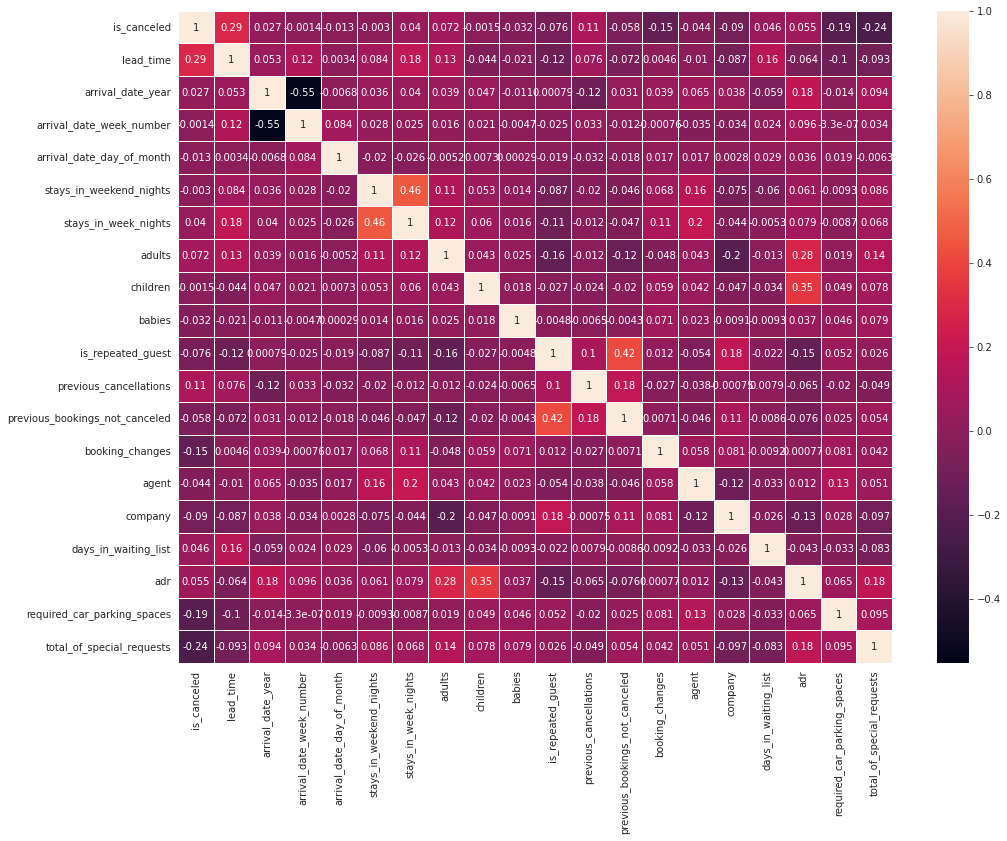

In [129]:
plt.figure(figsize = (16, 12))
corr = df.corr(method='pearson')
sns.heatmap(corr, annot = True, linewidths = 1)
plt.show()


In [130]:
correlation = df.corr()['is_canceled'].abs().sort_values(ascending = False)
correlation

is_canceled                       1.000000
lead_time                         0.286775
total_of_special_requests         0.242229
required_car_parking_spaces       0.191415
booking_changes                   0.147406
previous_cancellations            0.111370
company                           0.090339
is_repeated_guest                 0.076287
adults                            0.072235
previous_bookings_not_canceled    0.057799
adr                               0.054957
days_in_waiting_list              0.046047
agent                             0.044330
stays_in_week_nights              0.039767
babies                            0.031683
arrival_date_year                 0.027019
arrival_date_day_of_month         0.012713
stays_in_weekend_nights           0.002962
children                          0.001480
arrival_date_week_number          0.001401
Name: is_canceled, dtype: float64

từ kết quả phân tích ở trên ta tiến hành xoá các cột không hữu ích trong dữ liệu.

In [131]:
useless_col = ['days_in_waiting_list', 'arrival_date_year', 'arrival_date_year', 'assigned_room_type', 'booking_changes',
               'reservation_status', 'country', 'days_in_waiting_list']

df.drop(useless_col, axis = 1, inplace = True)

/home/dotoki/my_env/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [132]:
#df
records = df[df['is_canceled'] == 1]
records
# for i in records:
#   print(i)

,hotel,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,previous_bookings_not_canceled,reserved_room_type,deposit_type,agent,company,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date
69704,City Hotel,1,173,June,23,4,2,2,2,0.0,...,0,A,Non Refund,37.0,0.0,Transient,120.00,0,0,2016-12-13
48915,City Hotel,1,79,April,14,2,1,1,2,0.0,...,0,A,No Deposit,9.0,0.0,Transient,76.50,0,0,2016-01-14
9485,Resort Hotel,1,183,December,49,3,2,1,2,0.0,...,0,A,Non Refund,38.0,0.0,Transient,72.00,0,0,2016-10-26
51731,City Hotel,1,158,May,22,24,0,2,1,0.0,...,0,A,Non Refund,37.0,0.0,Transient,130.00,0,0,2016-01-18
72793,City Hotel,1,111,August,32,6,2,5,3,0.0,...,0,D,No Deposit,9.0,0.0,Transient,195.00,0,0,2017-04-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55632,City Hotel,1,405,August,34,18,0,2,2,0.0,...,0,A,Non Refund,1.0,0.0,Transient,62.00,0,0,2015-10-21
11101,Resort Hotel,1,100,April,16,18,2,5,2,0.0,...,0,E,No Deposit,240.0,0.0,Transient,94.29,0,0,2017-01-09
62351,City Hotel,1,3,January,2,10,0,4,2,0.0,...,0,A,No Deposit,9.0,0.0,Transient,83.09,0,1,2017-01-10
76150,City Hotel,1,273,July,29,17,0,2,2,0.0,...,0,A,No Deposit,6.0,0.0,Transient-Party,101.50,0,0,2015-07-06


Xử lí những dòng dữ liệu không có số để tạo khung dữ liệu số và phân loại.

In [133]:
cat_cols = [col for col in df.columns if df[col].dtype == 'O']
cat_cols

['hotel',
 'arrival_date_month',
 'meal',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'deposit_type',
 'customer_type',
 'reservation_status_date']

In [134]:
cat_df = df[cat_cols]
cat_df.head()

,hotel,arrival_date_month,meal,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type,reservation_status_date
69704,City Hotel,June,BB,Groups,TA/TO,A,Non Refund,Transient,2016-12-13
97516,City Hotel,September,BB,Online TA,TA/TO,D,No Deposit,Transient,2016-09-17
34791,Resort Hotel,April,HB,Online TA,TA/TO,G,No Deposit,Transient,2017-04-05
48915,City Hotel,April,SC,Online TA,TA/TO,A,No Deposit,Transient,2016-01-14
34836,Resort Hotel,April,BB,Offline TA/TO,TA/TO,A,No Deposit,Group,2017-04-14


In [135]:
cat_df['reservation_status_date'] = pd.to_datetime(cat_df['reservation_status_date'])

cat_df['year'] = cat_df['reservation_status_date'].dt.year
cat_df['month'] = cat_df['reservation_status_date'].dt.month
cat_df['day'] = cat_df['reservation_status_date'].dt.day

/tmp/ipykernel_1954049/969594972.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df['reservation_status_date'] = pd.to_datetime(cat_df['reservation_status_date'])
/tmp/ipykernel_1954049/969594972.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df['year'] = cat_df['reservation_status_date'].dt.year
/tmp/ipykernel_1954049/969594972.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [136]:
cat_df.drop(['reservation_status_date','arrival_date_month'] , axis = 1, inplace = True)

/home/dotoki/my_env/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [137]:
cat_df.head()

,hotel,meal,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type,year,month,day
69704,City Hotel,BB,Groups,TA/TO,A,Non Refund,Transient,2016,12,13
97516,City Hotel,BB,Online TA,TA/TO,D,No Deposit,Transient,2016,9,17
34791,Resort Hotel,HB,Online TA,TA/TO,G,No Deposit,Transient,2017,4,5
48915,City Hotel,SC,Online TA,TA/TO,A,No Deposit,Transient,2016,1,14
34836,Resort Hotel,BB,Offline TA/TO,TA/TO,A,No Deposit,Group,2017,4,14


xuất các giá trị duy nhất của mỗi cột

In [138]:
for col in cat_df.columns:
    print(f"{col}: \n{cat_df[col].unique()}\n")

hotel: 
['City Hotel' 'Resort Hotel']

meal: 
['BB' 'HB' 'SC' 'FB' 'Undefined']

market_segment: 
['Groups' 'Online TA' 'Offline TA/TO' 'Direct' 'Complementary' 'Corporate'
 'Aviation']

distribution_channel: 
['TA/TO' 'Direct' 'Corporate' 'GDS']

reserved_room_type: 
['A' 'D' 'G' 'F' 'E' 'H' 'C' 'B' 'L']

deposit_type: 
['Non Refund' 'No Deposit' 'Refundable']

customer_type: 
['Transient' 'Group' 'Transient-Party' 'Contract']

year: 
[2016 2017 2015 2014]

month: 
[12  9  4  1 11  3 10  8  6  2  7  5]

day: 
[13 17  5 14  1 26 18 25  8  6 28  4  3 29 19 30 10 24 21 12  9 27 22 31
 15  7 20 16  2 23 11]



mã hoá các biến phân loại


In [139]:
cat_df['hotel'] = cat_df['hotel'].map({'Resort Hotel' : 0, 'City Hotel' : 1})

cat_df['meal'] = cat_df['meal'].map({'BB' : 0, 'FB': 1, 'HB': 2, 'SC': 3, 'Undefined': 4})

cat_df['market_segment'] = cat_df['market_segment'].map({'Direct': 0, 'Corporate': 1, 'Online TA': 2, 'Offline TA/TO': 3,
                                                           'Complementary': 4, 'Groups': 5, 'Undefined': 6, 'Aviation': 7})

cat_df['distribution_channel'] = cat_df['distribution_channel'].map({'Direct': 0, 'Corporate': 1, 'TA/TO': 2, 'Undefined': 3,
                                                                       'GDS': 4})

cat_df['reserved_room_type'] = cat_df['reserved_room_type'].map({'C': 0, 'A': 1, 'D': 2, 'E': 3, 'G': 4, 'F': 5, 'H': 6,
                                                                   'L': 7, 'B': 8})

cat_df['deposit_type'] = cat_df['deposit_type'].map({'No Deposit': 0, 'Refundable': 1, 'Non Refund': 3})

cat_df['customer_type'] = cat_df['customer_type'].map({'Transient': 0, 'Contract': 1, 'Transient-Party': 2, 'Group': 3})

cat_df['year'] = cat_df['year'].map({2015: 0, 2014: 1, 2016: 2, 2017: 3})

/tmp/ipykernel_1954049/1679596210.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df['hotel'] = cat_df['hotel'].map({'Resort Hotel' : 0, 'City Hotel' : 1})
/tmp/ipykernel_1954049/1679596210.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df['meal'] = cat_df['meal'].map({'BB' : 0, 'FB': 1, 'HB': 2, 'SC': 3, 'Undefined': 4})
/tmp/ipykernel_1954049/1679596210.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [140]:
cat_df.head()

,hotel,meal,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type,year,month,day
69704,1,0,5,2,1,3,0,2,12,13
97516,1,0,2,2,2,0,0,2,9,17
34791,0,2,2,2,4,0,0,3,4,5
48915,1,3,2,2,1,0,0,2,1,14
34836,0,0,3,2,1,0,3,3,4,14


In [141]:
num_df = df.drop(columns = cat_cols, axis = 1)
num_df.drop('is_canceled', axis = 1, inplace = True)
num_df

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,agent,company,adr,required_car_parking_spaces,total_of_special_requests
69704,173,23,4,2,2,2,0.0,0,0,0,0,37.0,0.0,120.00,0,0
97516,17,38,16,0,1,2,0.0,0,0,0,0,9.0,0.0,183.00,0,1
34791,89,14,3,1,1,2,2.0,0,0,0,0,240.0,0.0,194.00,0,0
48915,79,14,2,1,1,2,0.0,0,0,0,0,9.0,0.0,76.50,0,0
34836,10,15,10,1,3,2,0.0,0,0,0,1,146.0,0.0,61.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46752,151,4,19,0,2,1,0.0,0,0,0,0,19.0,0.0,71.00,0,0
62351,3,2,10,0,4,2,0.0,0,0,0,0,9.0,0.0,83.09,0,1
3674,165,53,30,0,4,1,0.0,0,0,0,0,308.0,0.0,84.50,0,0
76150,273,29,17,0,2,2,0.0,0,0,1,0,6.0,0.0,101.50,0,0


In [142]:
num_df.var()

lead_time                         11513.890370
arrival_date_week_number            187.563166
arrival_date_day_of_month            75.895953
stays_in_weekend_nights               0.944575
stays_in_week_nights                  3.299225
adults                                0.263752
children                              0.156739
babies                                0.019134
is_repeated_guest                     0.031305
previous_cancellations                0.651709
previous_bookings_not_canceled        2.909419
agent                             11297.529256
company                            2955.226664
adr                                2333.297846
required_car_parking_spaces           0.056357
total_of_special_requests             0.618397
dtype: float64

Chuẩn hoá các biến số 

In [143]:
num_df['lead_time'] = np.log(num_df['lead_time'] + 1)
num_df['arrival_date_week_number'] = np.log(num_df['arrival_date_week_number'] + 1)
num_df['arrival_date_day_of_month'] = np.log(num_df['arrival_date_day_of_month'] + 1)
num_df['agent'] = np.log(num_df['agent'] + 1)
num_df['company'] = np.log(num_df['company'] + 1)
num_df['adr'] = np.log(num_df['adr'] + 1)

In [144]:
num_df.var()

lead_time                         2.598076
arrival_date_week_number          0.449222
arrival_date_day_of_month         0.498820
stays_in_weekend_nights           0.944575
stays_in_week_nights              3.299225
adults                            0.263752
children                          0.156739
babies                            0.019134
is_repeated_guest                 0.031305
previous_cancellations            0.651709
previous_bookings_not_canceled    2.909419
agent                             3.484395
company                           1.372760
adr                               0.559169
required_car_parking_spaces       0.056357
total_of_special_requests         0.618397
dtype: float64

In [145]:
num_df['adr'] = num_df['adr'].fillna(value = num_df['adr'].mean())
num_df.head()

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,agent,company,adr,required_car_parking_spaces,total_of_special_requests
69704,5.159055,3.178054,1.609438,2,2,2,0.0,0,0,0,0,3.637586,0.0,4.795791,0,0
97516,2.890372,3.663562,2.833213,0,1,2,0.0,0,0,0,0,2.302585,0.0,5.214936,0,1
34791,4.499810,2.708050,1.386294,1,1,2,2.0,0,0,0,0,5.484797,0.0,5.273000,0,0
48915,4.382027,2.708050,1.098612,1,1,2,0.0,0,0,0,0,2.302585,0.0,4.350278,0,0
34836,2.397895,2.772589,2.397895,1,3,2,0.0,0,0,0,1,4.990433,0.0,4.127134,0,1


In [146]:
X = pd.concat([cat_df, num_df], axis = 1)
y = df['is_canceled']

In [147]:
df.to_csv('dl.csv')
df

,hotel,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,previous_bookings_not_canceled,reserved_room_type,deposit_type,agent,company,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date
69704,City Hotel,1,173,June,23,4,2,2,2,0.0,...,0,A,Non Refund,37.0,0.0,Transient,120.00,0,0,2016-12-13
97516,City Hotel,0,17,September,38,16,0,1,2,0.0,...,0,D,No Deposit,9.0,0.0,Transient,183.00,0,1,2016-09-17
34791,Resort Hotel,0,89,April,14,3,1,1,2,2.0,...,0,G,No Deposit,240.0,0.0,Transient,194.00,0,0,2017-04-05
48915,City Hotel,1,79,April,14,2,1,1,2,0.0,...,0,A,No Deposit,9.0,0.0,Transient,76.50,0,0,2016-01-14
34836,Resort Hotel,0,10,April,15,10,1,3,2,0.0,...,1,A,No Deposit,146.0,0.0,Group,61.00,0,1,2017-04-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46752,City Hotel,0,151,January,4,19,0,2,1,0.0,...,0,A,No Deposit,19.0,0.0,Transient-Party,71.00,0,0,2016-01-21
62351,City Hotel,1,3,January,2,10,0,4,2,0.0,...,0,A,No Deposit,9.0,0.0,Transient,83.09,0,1,2017-01-10
3674,Resort Hotel,0,165,December,53,30,0,4,1,0.0,...,0,A,No Deposit,308.0,0.0,Transient-Party,84.50,0,0,2016-01-03
76150,City Hotel,1,273,July,29,17,0,2,2,0.0,...,0,A,No Deposit,6.0,0.0,Transient-Party,101.50,0,0,2015-07-06


In [148]:
X.shape, y.shape

((9985, 26), (9985,))

lấy 100 dòng dữ liệu ra để test thử 

In [149]:
# lấy random 100 dòng bên X
x_backup = X
y_backup = y
validate_x = X.sample(n=100);
array_index = validate_x.index.to_list()

#tiến hành chạy for để xoá các dòng đã lấy radom và sau đó lấy dòng với index tương ứng bên y:
array_y = []
for i in array_index:
  X = X.drop(index=i)
  array_y.append(y.loc[i])
  y = y.drop(index= i)
validate_y = pd.DataFrame(array_y)

In [150]:
validate_x.shape

(100, 26)

In [151]:
validate_y.shape

(100, 1)

In [152]:
X.shape, y.shape

((9885, 26), (9885,))

Tiến hành chia dữ liệu thành 2 tập Train và Test.

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

In [154]:
df_train = pd.concat([X_train, y_train], axis = 1)
dfTrain = df_train[['hotel', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type','previous_cancellations', 'previous_bookings_not_canceled', 'is_canceled']]
dfTrain

,hotel,meal,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type,previous_cancellations,previous_bookings_not_canceled,is_canceled
92365,1,0,2,2,1,0,0,0,0,0
62351,1,0,2,2,1,0,0,0,0,1
36570,0,2,2,2,1,0,0,0,0,0
117720,1,0,3,2,1,0,0,0,0,0
83180,1,0,4,0,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
103974,1,0,3,2,1,0,2,0,0,0
19464,0,2,3,2,2,0,0,0,0,0
16815,0,0,2,2,5,0,0,0,0,0
103102,1,0,3,2,1,0,2,0,0,0


In [155]:
df_test = pd.concat([X_test, y_test], axis = 1)
dfTest = df_test[['hotel', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type','previous_cancellations', 'previous_bookings_not_canceled', 'is_canceled']]
dfTest

,hotel,meal,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type,previous_cancellations,previous_bookings_not_canceled,is_canceled
36301,0,0,2,2,1,0,0,0,0,0
53297,1,0,5,2,1,3,0,0,0,1
93201,1,3,3,2,1,0,0,0,0,0
34111,0,0,2,2,1,0,0,0,0,0
14971,0,1,5,2,1,3,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...
103674,1,0,1,1,1,0,0,0,0,0
60081,1,0,2,2,1,0,0,0,0,1
9748,0,0,2,2,2,0,0,0,0,1
2705,0,0,0,0,3,0,0,0,0,0


# Thuật Toán


In [156]:
def checkPurity(df_train):
  if len(df_train.rdd.map(lambda row:row[-1]).distinct().collect()) == 1:
    return True
  else:
    return False

def getMaxClassify(df_train):
  rdd = df_train.rdd.map(lambda row:row[-1]).map(lambda s: (s,1)).reduceByKey(lambda x,y: x+y)
  return rdd.max()[0]


In [157]:
def getPotentialSplits(df_train):
  wsize=1
  windUdf = F.udf( lambda x: str(np.nanmean(x)), StringType())
  w = Window.partitionBy('0').orderBy("id").rowsBetween(0, wsize)
  df_train_later = df_train.select(df_train.columns[0]).distinct().sort(df_train.columns[0]).withColumn('0', lit(0)).withColumn("id", monotonically_increasing_id()).withColumn('rtd_list', F.collect_list(df_train.columns[0]).over(w)).select('0','rtd_list')

  potential_splits = df_train_later.withColumn("two_average", windUdf("rtd_list")).select('0','two_average').limit(df_train_later.count()-1).rdd

  for i in range(1,len(df_train.columns)-1):
    w_for = Window.partitionBy(str(i)).orderBy("id").rowsBetween(0, wsize)
    df_train_later = df_train.select(df_train.columns[i]).distinct().sort(df_train.columns[i]).withColumn('0', lit(i)).withColumn("id", monotonically_increasing_id()).withColumn('rtd_list', F.collect_list(df_train.columns[i]).over(w)).select('0','rtd_list')

    rdd_for = df_train_later.withColumn("two_average", windUdf("rtd_list")).select('0','two_average').limit(df_train_later.count()-1).rdd
    potential_splits = sc.union([potential_splits,rdd_for]) 
  return potential_splits

In [158]:
def calEntropy(df_train):
  rdd = df_train.rdd.map(lambda row:row[-1]).map(lambda s: (s,1)).reduceByKey(lambda x,y:x+y)
  counts_sum = rdd.map(lambda item:item[1]).reduce(lambda x,y:x+y)
  probabilities = rdd.map(lambda item:item[1]).map(lambda item:item/counts_sum)
  entropy = probabilities.map(lambda item: item * -np.log2(item)).reduce(lambda x,y:x+y)
  return float(entropy)

def calOvEntropy(data_left, data_right):
   n_data_points = data_left.count() + data_right.count()
   p_data_left = data_left.count()/n_data_points
   p_data_right = data_right.count()/n_data_points
   overall_entropy = (p_data_left * calEntropy(data_left) + p_data_right * calEntropy(data_right))
   return overall_entropy

In [159]:
def splitData(df_train, split_column, split_value):
  split_column_values = df_train[df_train.columns[split_column]]
  data_left = df_train.filter(split_column_values <= split_value)
  data_right = df_train.filter(split_column_values > split_value)
  return data_left, data_right

  
def determineBestSplit(data,potenial_splits):
  overall_entropy = 999
  potential_splits = getPotentialSplits(data)
  for i in potential_splits.collect():
    data_left, data_right = splitData(data,split_column=i[0], split_value=i[1])
    current_overall_entropy = calOvEntropy(data_left, data_right)
    if current_overall_entropy < overall_entropy:
      overall_entropy = current_overall_entropy
      best_split_column = i[0]
      best_split_value = i[1]
  return best_split_column, best_split_value


In [160]:
def buildDeciTree(df,counter=0,min_samples=2, max_depth=5):
  global COLUMN_HEADERS
  COLUMN_HEADERS = df.columns
  data = df
  if checkPurity(data) or (data.count() < min_samples) or (counter == max_depth):
    classification = getMaxClassify(data)
    return classification
  else:
    counter += 1
    potential_splits = getPotentialSplits(data)
    split_column,split_value = determineBestSplit(data,potential_splits)
    
    data_left, data_right = splitData(data,split_column,split_value)
    
    feature_name = COLUMN_HEADERS[split_column]
    
    question = "{} <= {}".format(feature_name,split_value)
    sub_tree = {question:[]}

    yes_ans = buildDeciTree(data_left,counter, min_samples, max_depth)
    no_ans = buildDeciTree(data_right,counter, min_samples, max_depth)
    
    if yes_ans == no_ans:
      sub_tree = yes_ans
    else:
      sub_tree[question].append(yes_ans)
      sub_tree[question].append(no_ans) 
    return sub_tree

In [161]:

def classifyEx(hotel, meal, market_segment, distribution_channel, reserved_room_type,
                     deposit_type, customer_type, previous_cancellations, previous_bookings_not_canceled, tree):

  tree = ast.literal_eval(str(tree))
  question = list(tree.keys())[0]
  feature_name, comparison_operator, value = question.split()

  a = ['hotel', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type','previous_cancellations', 'previous_bookings_not_canceled']
  b = [hotel, meal, market_segment, distribution_channel, reserved_room_type,
        deposit_type, customer_type, previous_cancellations, previous_bookings_not_canceled]

  if b[a.index(feature_name)] <= float(value):
      answer = tree[question][0]
  else:
      answer = tree[question][1]
  if not isinstance(answer, dict):
    return answer
  else:
    residual_tree = answer
    return classifyEx(hotel, meal, market_segment, distribution_channel, reserved_room_type,
                     deposit_type, customer_type, previous_cancellations, previous_bookings_not_canceled, residual_tree)

In [162]:
sum_cols = udf(classifyEx, StringType())
def scoreDeciTree(df,tree):
  global sum_cols
  df_kq = df.withColumn('tree', lit(str(tree))).withColumn('result', sum_cols(F.col( 'hotel' ),F.col('meal'),
                                F.col('market_segment' ), F.col('distribution_channel'), F.col( 'reserved_room_type' ),
                                F.col('deposit_type'), F.col('customer_type' ),F.col('previous_cancellations'),F.col('previous_bookings_not_canceled'),
                                F.col('tree')))
  
  rdd_kq = df_kq.withColumn( 'is_canceled' ,df_kq.is_canceled.cast('Integer')).withColumn('result', df_kq.result.cast('Integer')).select( 'is_canceled', 'result').rdd
  
  rdd_acc = rdd_kq.map(lambda x: 1 if x[0] == x[1] else 0)
  acc = rdd_acc.reduce(lambda a,b: a+b)/rdd_acc.count()

  tp = rdd_kq.map(lambda x: 1 if (x[0] == 0 and x[1]==0) else 0).reduce(lambda a,b: a+b)
  fp = rdd_kq.map(lambda x: 1 if (x[0] == 1 and x[1]==0) else 0).reduce(lambda a,b: a+b)
  fn = rdd_kq.map(lambda x: 1 if (x[0] == 0 and x[1]==1) else 0).reduce(lambda a,b: a+b)
  tn = rdd_kq.map(lambda x: 1 if (x[0] == 1 and x[1]==1) else 0).reduce(lambda a,b: a+b)

  lo_cm = np.array([[tp, fn], [fp,tn]])
  return acc, lo_cm

In [163]:

#Create PySpark DataFrame from Pandas
sparkDFTrain = spark.createDataFrame(dfTrain) 
sparkDFTest = spark.createDataFrame(dfTest) 

In [164]:
now = datetime.now()

startTime = now.strftime("%H:%M:%S")
print("Start at ", startTime)

Start at  22:51:57


In [165]:
tree = buildDeciTree(sparkDFTrain)


In [166]:
acc, lo_cm = scoreDeciTree(sparkDFTest, tree)

Text(0.5, 1.0, 'Decision Tree Accuracy Score : 0.3782872555630479')

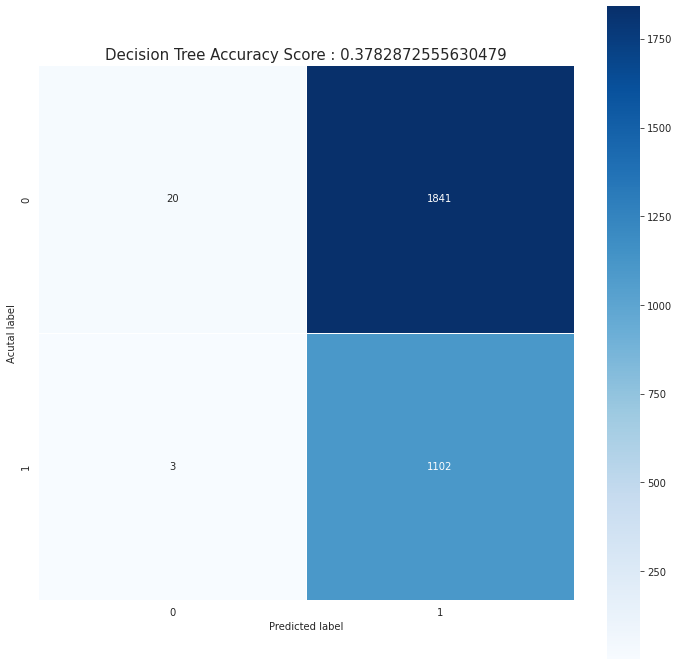

In [167]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,12))
sns.heatmap(lo_cm, annot=True, fmt= ".0f", linewidths = .5, square = True, cmap ='Blues')
plt.xlabel("Predicted label")
plt.ylabel("Acutal label")
title = "Decision Tree Accuracy Score : {0}".format(acc)
plt.title(title, size = 15)

In [168]:
now = datetime.now()

endTime = now.strftime("%H:%M:%S")
print("Finish At : ", endTime)

Finish At :  23:09:58


# Chạy bằng thư viện

In [169]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris

In [170]:
a = ['hotel', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type','previous_cancellations', 'previous_bookings_not_canceled']

In [171]:
va = VectorAssembler(inputCols = a, outputCol = 'features')
va_dfTrain = va.transform(sparkDFTrain)
va_dfTrain = va_dfTrain.selectExpr('features as features','is_canceled as label')
va_dfTrain = va_dfTrain.select(['features','label'])
va_dfTrain.count()

6919

In [172]:
va_dfTest = va.transform(sparkDFTest)
va_dfTest = va_dfTest.selectExpr('features as features', 'is_canceled as label')
va_dfTest = va_dfTest.select(['features','label'])
va_dfTest.show(6)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(9,[2,3,4],[2.0,2...|    0|
|[1.0,0.0,5.0,2.0,...|    1|
|[1.0,3.0,3.0,2.0,...|    0|
|(9,[2,3,4],[2.0,2...|    0|
|[0.0,1.0,5.0,2.0,...|    1|
|(9,[0,2,3,4],[1.0...|    1|
+--------------------+-----+
only showing top 6 rows



In [173]:
dtc = DecisionTreeClassifier(featuresCol="features", labelCol="label")
dtc = dtc.fit(va_dfTrain)
pred = dtc.transform(va_dfTest)
pred.show(3)


+--------------------+-----+---------------+--------------------+----------+
|            features|label|  rawPrediction|         probability|prediction|
+--------------------+-----+---------------+--------------------+----------+
|(9,[2,3,4],[2.0,2...|    0|[4355.0,1569.0]|[0.73514517218095...|       0.0|
|[1.0,0.0,5.0,2.0,...|    1|    [0.0,743.0]|           [0.0,1.0]|       1.0|
|[1.0,3.0,3.0,2.0,...|    0|[4355.0,1569.0]|[0.73514517218095...|       0.0|
+--------------------+-----+---------------+--------------------+----------+
only showing top 3 rows



Prediction Accuracy:  0.3782872555630479


Text(0.5, 1.0, 'Decision Tree Accuracy Score : 0.7263019140249319')

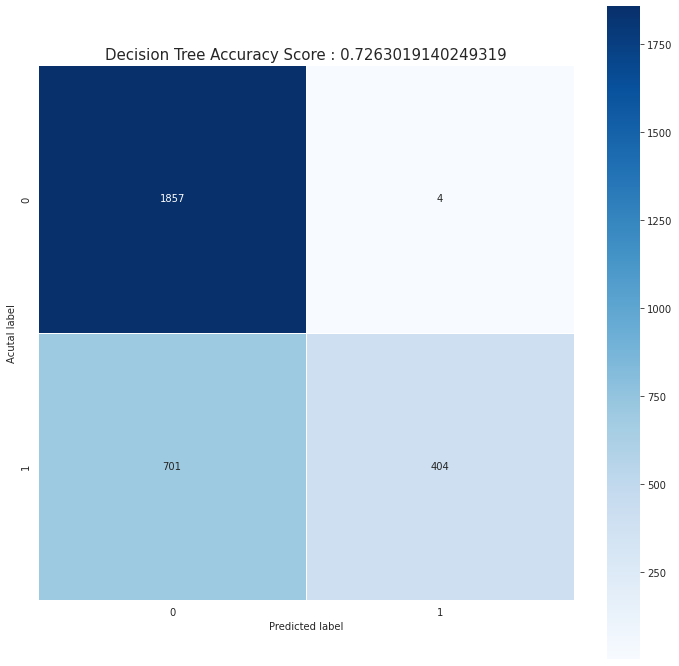

In [174]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
acc2 = evaluator.evaluate(pred)
print("Prediction Accuracy: ", acc)
 
y_pred=pred.select("prediction").collect()
y_orig=pred.select("label").collect()

cm = confusion_matrix(y_orig, y_pred)

plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, fmt= ".0f", linewidths = .5, square = True, cmap ='Blues')
plt.xlabel("Predicted label")
plt.ylabel("Acutal label")
title = "Decision Tree Accuracy Score : {0}".format(acc2)
plt.title(title, size = 15)